In [11]:
import sys
import os

# Set the execution path
sys.path.append(os.path.abspath('../../'))

import math
import numpy as np
from algorithm.sum_dp_module import SumDP
from algorithm.laplace_module import LaplaceMechanism
from algorithm.error_evaluation.SumDP_eva import SumDPExperiment
from algorithm.error_evaluation.laplace_eva import LaplaceExperiment
import pandas as pd

In [19]:
import os

# load datasets
base_path = os.path.abspath(os.path.join('..', '..', 'datasets'))
loan_df = pd.read_csv(os.path.join(base_path, 'loan_data.csv'))
insurance_df = pd.read_csv(os.path.join(base_path, 'insurance.csv'))
students_df = pd.read_csv(os.path.join(base_path, 'StudentsPerformance.csv'))

# show the first few rows of each dataset
print("Loan Dataset:")
print(loan_df.head())

print("\nInsurance Dataset:")
print(insurance_df.head())

print("\nStudents Performance Dataset:")
print(students_df.head())

# process the datasets
loan_data = loan_df['LoanAmount'].dropna().astype(int).tolist()
insurance_data = insurance_df['charges'].dropna().astype(int).tolist()
students_data = students_df['math score'].dropna().astype(int).tolist()

# print the first few elements of each dataset
print("LoanAmount sample:", loan_data[:5])
print("Charges sample:", insurance_data[:5])
print("Math score sample:", students_data[:5])



datasets = {
    "loan": loan_data,
    "insurance": insurance_data,
    "students": students_data
}

print(max(loan_data))
print(max(insurance_data))
print(max(students_data))

Loan Dataset:
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001003   Male     Yes          1      Graduate            No   
1  LP001005   Male     Yes          0      Graduate           Yes   
2  LP001006   Male     Yes          0  Not Graduate            No   
3  LP001008   Male      No          0      Graduate            No   
4  LP001013   Male     Yes          0  Not Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             4583             1508.0       128.0             360.0   
1             3000                0.0        66.0             360.0   
2             2583             2358.0       120.0             360.0   
3             6000                0.0       141.0             360.0   
4             2333             1516.0        95.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Rural           N  
1             1.0         Urban           Y  
2     

In [20]:
# Set up differential privacy parameters
epsilons = [0.2, 0.5, 0.8, 1.0, 1.2, 2, 3, 5]        # Privacy budgets
beta = 1e-5                                          # Failure probability parameter (typically set to 1e-5)
# n_trials is set to 1000 by default in the evaluation function

# Set upper bounds for each dataset
U_loan = 512        # Upper bound for loan amount, max(D) = 150
U_charge = 2**18    # Upper bound for medical charges, max(D) = 63770
U_math = 300        # Upper bound for math scores, max(D) = 100

datasets_U = {
    "loan": U_loan,
    "insurance": U_charge,
    "students": U_math
}

results = []

# Iterate through each dataset
for name, data in datasets.items():
    max_val = max(data)
    U = datasets_U[name]
    clipped_data = [min(max(int(x), 0), U) for x in data]
    true_sum = sum(clipped_data)

    for epsilon in epsilons:
        # Initialize mechanisms
        sumdp_instance = SumDP(epsilon=epsilon, beta=beta, U=U)
        laplace_instance = LaplaceMechanism(epsilon=epsilon, sensitivity=U)

        # Initialize evaluators
        sumdp_eval = SumDPExperiment(sumdp_instance, clipped_data)
        laplace_eval = LaplaceExperiment(laplace_instance, clipped_data)

        # Run experiments
        sumdp_mean = sumdp_eval.run_experiment()
        laplace_mean = laplace_eval.run_experiment()

         # Save results
        results.append({
            'Dataset': name,
            'Epsilon': epsilon,
            'Max(D)': max_val,
            'U': U,
            'True Sum': true_sum,
            'SumDP Error': round(sumdp_mean, 2),
            'Laplace Error': round(laplace_mean, 2),
            'SumDP Bound': round(sumdp_eval.theoretical_error_bound(), 2),
            'Laplace Bound': round(laplace_eval.theoretical_error_bound(beta), 2)
        })


In [21]:
df_results = pd.DataFrame(results)
print(df_results)

      Dataset  Epsilon  Max(D)       U  True Sum  SumDP Error  Laplace Error  \
0        loan      0.2     150     512     40000     11544.20        2564.67   
1        loan      0.5     150     512     40000       679.38        1050.86   
2        loan      0.8     150     512     40000       372.70         644.79   
3        loan      1.0     150     512     40000       315.74         542.58   
4        loan      1.2     150     512     40000       268.07         424.22   
5        loan      2.0     150     512     40000       153.57         257.26   
6        loan      3.0     150     512     40000       107.60         180.37   
7        loan      5.0     150     512     40000        59.44          99.01   
8   insurance      0.2   63770  262144  17755165   4531417.75     1307334.47   
9   insurance      0.5   63770  262144  17755165    161082.36      547378.73   
10  insurance      0.8   63770  262144  17755165     96952.10      330410.39   
11  insurance      1.0   63770  262144  

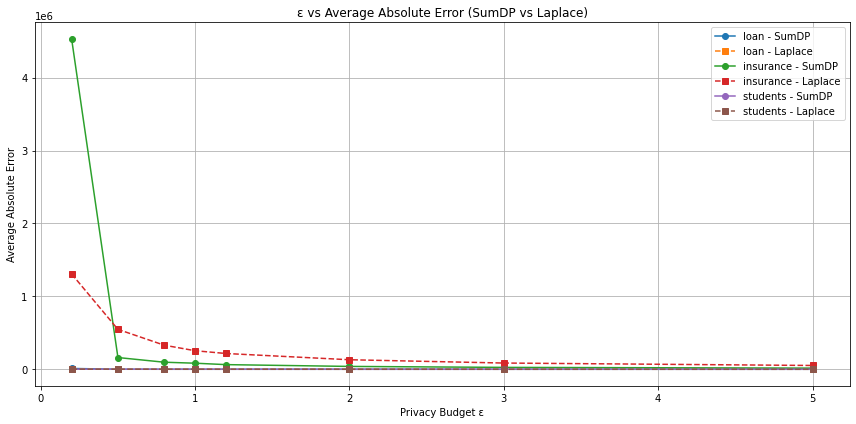

In [22]:
import matplotlib.pyplot as plt

# Collapse data for each dataset and mechanism
datasets = df_results["Dataset"].unique()
epsilons = sorted(df_results["Epsilon"].unique())

plt.figure(figsize=(12, 6))

for dataset in datasets:
    df_subset = df_results[df_results["Dataset"] == dataset]
    
    sumdp_y = df_subset["SumDP Error"].tolist()
    laplace_y = df_subset["Laplace Error"].tolist()

    plt.plot(epsilons, sumdp_y, marker='o', label=f"{dataset} - SumDP")
    plt.plot(epsilons, laplace_y, marker='s', linestyle='--', label=f"{dataset} - Laplace")

plt.title("ε vs Average Absolute Error (SumDP vs Laplace)")
plt.xlabel("Privacy Budget ε")
plt.ylabel("Average Absolute Error")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


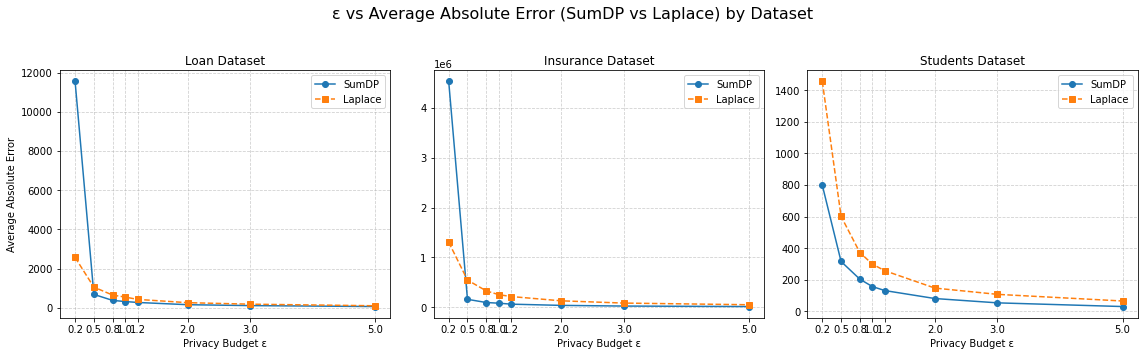

In [23]:
import matplotlib.pyplot as plt

# Unique datasets and epsilon values
datasets = df_results["Dataset"].unique()
epsilons = sorted(df_results["Epsilon"].unique())

# Create subplots
fig, axs = plt.subplots(1, len(datasets), figsize=(16, 5), sharey=False)

for i, dataset in enumerate(datasets):
    ax = axs[i]
    df_subset = df_results[df_results["Dataset"] == dataset].sort_values("Epsilon")

    sumdp_y = df_subset["SumDP Error"].tolist()
    laplace_y = df_subset["Laplace Error"].tolist()

    # Plot for each dataset
    ax.plot(epsilons, sumdp_y, marker='o', label="SumDP")
    ax.plot(epsilons, laplace_y, marker='s', linestyle='--', label="Laplace")

    ax.set_title(f"{dataset.capitalize()} Dataset")
    ax.set_xlabel("Privacy Budget ε")
    ax.set_xticks(epsilons)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

    if i == 0:
        ax.set_ylabel("Average Absolute Error")

# Overall title
plt.suptitle("ε vs Average Absolute Error (SumDP vs Laplace) by Dataset", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



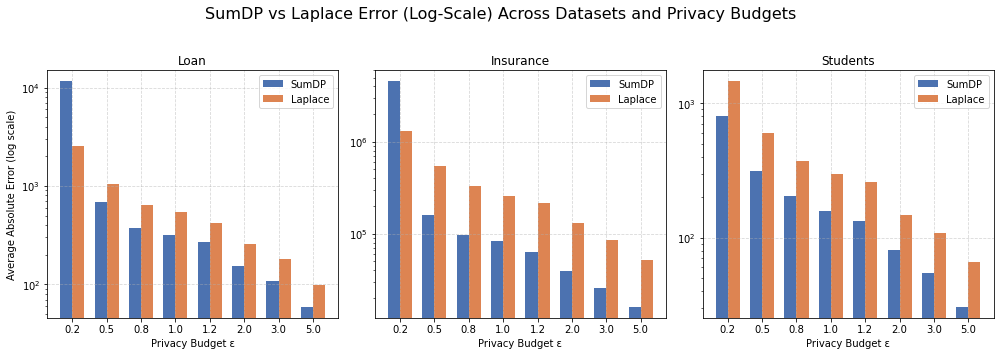

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_results

# Extract unique ε values and dataset names
epsilons = sorted(df["Epsilon"].unique())
datasets = df["Dataset"].unique()

# Set colors for each mechanism
colors = {
    "SumDP": "#4C72B0",      # Blue
    "Laplace": "#DD8452"     # Orange
}

# Create subplots
fig, axs = plt.subplots(1, len(datasets), figsize=(14, 5), sharey=False)
bar_width = 0.35
x = np.arange(len(epsilons))

for i, dataset in enumerate(datasets):
    ax = axs[i]
    df_subset = df[df["Dataset"] == dataset].sort_values("Epsilon")

    sumdp_errors = df_subset["SumDP Error"].values
    laplace_errors = df_subset["Laplace Error"].values

    # Plot grouped bars for SumDP and Laplace
    ax.bar(x - bar_width/2, sumdp_errors, width=bar_width, label="SumDP", color=colors["SumDP"])
    ax.bar(x + bar_width/2, laplace_errors, width=bar_width, label="Laplace", color=colors["Laplace"])

    ax.set_title(dataset.capitalize())
    ax.set_xticks(x)
    ax.set_xticklabels(epsilons)
    ax.set_xlabel("Privacy Budget ε")
    ax.set_yscale("log")  # Use log scale for better visibility across varying error magnitudes
    if i == 0:
        ax.set_ylabel("Average Absolute Error (log scale)")

    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

plt.suptitle("SumDP vs Laplace Error (Log-Scale) Across Datasets and Privacy Budgets", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


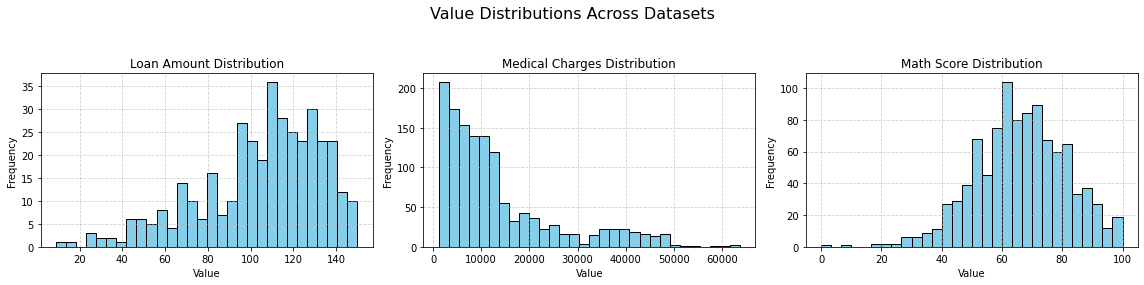

In [25]:
# Extract numerical columns for visualization 
datasets = {
    "Loan Amount": loan_df["LoanAmount"].dropna().tolist(),
    "Medical Charges": insurance_df["charges"].dropna().tolist(),
    "Math Score": students_df["math score"].dropna().tolist()
}

# Plot value distributions for each dataset using subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 4), sharey=False)

for ax, (title, values) in zip(axs, datasets.items()):
    ax.hist(values, bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f"{title} Distribution")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle='--', alpha=0.6)

plt.suptitle("Value Distributions Across Datasets", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


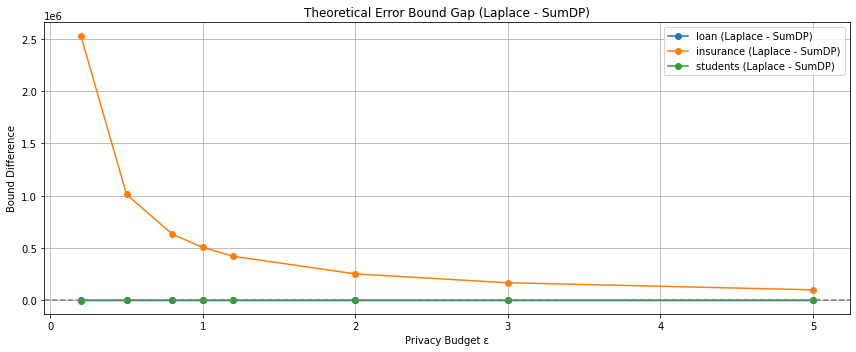

In [26]:
import matplotlib.pyplot as plt

# Add Bound Gap column (if not already part of the original append)
df_results["Bound Gap"] = df_results["Laplace Bound"] - df_results["SumDP Bound"]
df_results["Bound Gap"] = df_results["Bound Gap"].round(2)  # optional rounding


plt.figure(figsize=(12, 5))

for dataset in df_results["Dataset"].unique():
    df_subset = df_results[df_results["Dataset"] == dataset].sort_values("Epsilon")

    eps = df_subset["Epsilon"].values.flatten().tolist()
    gap = df_subset["Bound Gap"].values.flatten().tolist()

    plt.plot(
        eps,
        gap,
        marker='o',
        label=f"{dataset} (Laplace - SumDP)"
    )

plt.axhline(y=0, linestyle='--', color='gray')
plt.title("Theoretical Error Bound Gap (Laplace - SumDP)")
plt.xlabel("Privacy Budget ε")
plt.ylabel("Bound Difference")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

